In [74]:
!pip install pandas scikit-learn numpy seaborn matplotlib numpy tensorflow==1.15

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
  Using cached tensorflow-1.15.0-cp37-cp37m-manylinux2010_x86_64.whl (412.3 MB)
  Using cached tensorflow_estimator-1.15.1-py2.py3-none-any.whl (503 kB)
  Using cached tensorboard-1.15.0-py3-none-any.whl (3.8 MB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 1.14.0
    Uninstalling tensorflow-estimator-1.14.0:
      Successfully uninstalled tensorflow-estimator-1.14.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 1.14.0
    Uninstalling tensorboard-1.14.0:
      Successfully uninstalled tensorboard-1.14.0
  Rolling back uninstall of tensorboard
  Moving to /opt/conda/bin/tensorboard
   from /tmp/pip-uninstall-43qju711/tensorboard
  Moving to /opt/conda/lib/python3.7/site-packages/tensorboard-1.14.0.dist-info/
   from 

In [75]:
import input_data
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0" #Disable GPU TRAININT

In [76]:
# One_hot transforma las características (features) de una variable de valores discretos a una 
# codificación binaria en forma de vector.  

Train_data_file = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz'
Train_label_file = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz'
Test_data_file = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz'
Test_label_file = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz'

full_data = data = input_data.read_data_sets('data/fashion', 
                                             source_url='http://fashion-mnist.s3-website.eu-central-1.amazonaws.com',
                                             one_hot=True)

LABELS = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot',
}

Extracting data/fashion/train-images-idx3-ubyte.gz
Extracting data/fashion/train-labels-idx1-ubyte.gz
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Extracting data/fashion/t10k-labels-idx1-ubyte.gz


In [77]:
print("Conjunto de entrenamiento (Imágenes) shape: {shape}".format(shape=full_data.train.images.shape))
print("Conjunto de entrenamiento (Labels) shape: {shape}".format(shape=full_data.train.labels.shape))

# Shapes of test set
print("Conjunto de test (Imágenes) shape: {shape}".format(shape=full_data.test.images.shape))
print("Conjunto de test (Labels) shape: {shape}".format(shape=full_data.test.labels.shape))

Conjunto de entrenamiento (Imágenes) shape: (55000, 784)
Conjunto de entrenamiento (Labels) shape: (55000, 10)
Conjunto de test (Imágenes) shape: (10000, 784)
Conjunto de test (Labels) shape: (10000, 10)


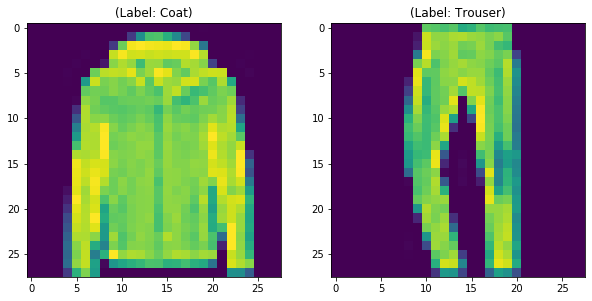

In [78]:
def plot_image(plt, data, label, size, location):
    plt.subplot(location)
    img = np.reshape(data, size)
    label = np.argmax(label)
    plt.imshow(img)
    plt.title("(Label: " + str(LABELS[label]) + ")")

plt.figure(figsize=[10,10])
plot_image(plt, 
           full_data.train.images[0], 
           full_data.train.labels[0,:], 
           (28, 28),
           121)
plot_image(plt, 
           full_data.test.images[5], 
           full_data.test.labels[5,:], 
           (28, 28),
           122)

In [210]:
size = 28

train_X = data.train.images
test_X = data.test.images

train_y = data.train.labels
test_y = data.test.labels

In [211]:
n_input = size * size
n_output = len(LABELS) 
weights = list()
biases = list()

def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x) 

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='SAME')

def fully_connected(x, w, b):
    x = tf.reshape(x, [-1, w.get_shape().as_list()[0]])
    x = tf.add(tf.matmul(x, w), b)
    return tf.nn.relu(x)

def generate_network(x, weights, biases, layers, drop_out=False, dropout=None):
    
    # Tensor input 4-D: [Batch Size, Height, Width, Channel]
    previous_layer = tf.reshape(x, shape=[-1, 28, 28, 1])
    new_layer = None
    
    for i in range(len(layers)-1):
        if layers[i] == 1: #Convolutional layer
            new_layer = conv2d(previous_layer, weights[i], biases[i])
            new_layer = maxpool2d(new_layer, k=2)
        
        if layers[i] == 2: #Fully connected layer
            new_layer = fully_connected(previous_layer, weights[i], biases[i])
        
        previous_layer = new_layer
        
    if drop_out:
        previous_layer = tf.nn.dropout(previous_layer, dropout)
    
    return tf.add(tf.matmul(previous_layer, weights[len(layers)-1]), biases[len(layers)-1])

In [212]:
tf.reset_default_graph()

x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_output])

#Capa convolucional 32 filtro 3x3
weights.append(tf.get_variable('W0', shape=(3,3,1,32)))
biases.append(tf.get_variable('B0', shape=(32)))
#Capa convolucional 64 filtro 3x3
weights.append(tf.get_variable('W1', shape=(3,3,32,64)))
biases.append(tf.get_variable('B1', shape=(64)))
#Capa Densa 1024 unidades
weights.append(tf.get_variable('D1', shape=(7*7*64, 1024)))
biases.append(tf.get_variable('BD1', shape=(1024)))
#Capa salida 10 clases
weights.append(tf.get_variable('OUT', shape=(1024,n_output)))
biases.append(tf.get_variable('BOUT', shape=(n_output)))

net = generate_network(x, weights, biases, [1, 1, 2, 3])

In [213]:
cost = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(
        logits=net, 
        labels=y))

optimizer = tf.train.AdamOptimizer(
    learning_rate=learning_rate).minimize(cost)

correct_prediction = tf.equal(tf.argmax(net, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [214]:
def train(training_iters, learning_rate, batch_size = 128):

    init = tf.global_variables_initializer()

    with tf.Session() as sess:

        sess.run(init) 

        train_loss = []
        test_loss = []
        train_accuracy = []
        test_accuracy = []

        summary_writer = tf.summary.FileWriter('./output', sess.graph)

        for epoch in range(training_iters):

            for batch in range(len(train_X)//batch_size):

                batch_x = train_X[batch*batch_size:min((batch+1)*batch_size,len(train_X))]
                batch_y = train_y[batch*batch_size:min((batch+1)*batch_size,len(train_y))]    

                opt = sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
                loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                                  y: batch_y})

            if (epoch + 1) % 10 == 0:
                print("Iteración " + str(epoch+1) + ", Loss= " + \
                      "{:.6f}".format(loss) + ", Exactitud= " + \
                      "{:.5f}".format(acc))
                
            test_acc, valid_loss = sess.run([accuracy,cost], feed_dict={x: test_X,y : test_y})
            train_loss.append(loss)
            test_loss.append(valid_loss)
            train_accuracy.append(acc)
            test_accuracy.append(test_acc)

        print("Aprendizaje finalizado")

        test_acc, valid_loss = sess.run([accuracy,cost], feed_dict={x: test_X,y : test_y})
        train_loss.append(loss)
        test_loss.append(valid_loss)
        train_accuracy.append(acc)
        test_accuracy.append(test_acc)
        print("Exactitud test:","{:.5f}".format(test_acc))

        summary_writer.close()
        
        return [train_loss, test_loss, train_accuracy, test_accuracy]
        
def print_results(train_loss, test_loss):
    
    plt.plot(range(len(train_loss)), train_loss, 'b', label='Loss entrenamiento')
    plt.plot(range(len(test_loss)), test_loss, 'r', label='Loss test')
    plt.title('Entrenamiento y test')
    plt.xlabel('Iteraciones',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.legend()
    plt.figure()
    plt.show()

Iteración 10, Loss= 0.091082, Exactitud= 0.94531
Aprendizaje finalizado
Exactitud test: 0.89510


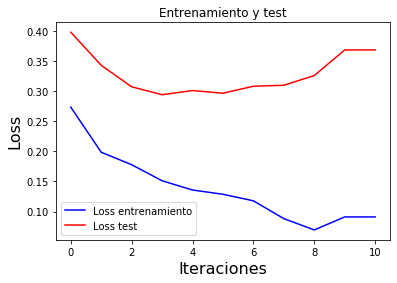

<Figure size 432x288 with 0 Axes>

In [215]:
results = train(10, 0.001, 128)
print_results(results[0], results[1])